# User-Movie Preference Trend

In this notebook, we want to analyze the trend in the preferences of users in movies. The user-movie preference trend can be obtained by observing how the users rate movies for different movie genres.

#### Objectives:

- Determine all the possible genres
- Filter the data for each genre
- Solve for the average rating of the movies per year
- Obtain the moving average to reduce noise in the data

***
### Identifying The Top Genres 

Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns


From the <code>title_basics.tsv</code> dataset, load the data in chunks filtering only the rows with <code>titleType</code> of <code>movie</code>.

In [2]:
df_movies = []
title_basics_col_list = ["tconst", "titleType", "primaryTitle", "startYear", "genres"]
iter_movie = pd.read_csv('title_basics.tsv', sep='\t', usecols=title_basics_col_list, iterator=True, na_values = '\\N', chunksize=10000)
df_movies = pd.concat([chunk[chunk['titleType']=="movie"] for chunk in iter_movie])
df_movies.head()

,tconst,titleType,primaryTitle,startYear,genres
498,tt0000502,movie,Bohemios,1905.0,NaN
570,tt0000574,movie,The Story of the Kelly Gang,1906.0,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,1907.0,Drama
610,tt0000615,movie,Robbery Under Arms,1907.0,Drama
625,tt0000630,movie,Hamlet,1908.0,Drama


Check for empty values, and then remove the rows with empty values since we are analyzing the trends in the genres of the movies.

In [3]:
df_movies.isna().sum()

tconst              0
titleType           0
primaryTitle        0
startYear       80372
genres          71576
dtype: int64

In [4]:
df_movies.dropna(inplace = True)
df_movies.isna().sum()

tconst          0
titleType       0
primaryTitle    0
startYear       0
genres          0
dtype: int64

Since there are no more empty rows, we can now proceed by counting all the possible genre strings in the <code>genres</code> column of <code>df_movies</code>.

In [5]:
genre_dict = dict()
for genre_per_movie in df_movies["genres"]:
    genre_per_movie = str(genre_per_movie)
    genre_in_movie = genre_per_movie.split(",")
    for genre in genre_in_movie:
        #genre = genre.lower()
        if genre in genre_dict:
            genre_dict[genre] += 1
        else:
            genre_dict[genre] = 1
print(genre_dict)

{'Action': 42138, 'Adventure': 22823, 'Biography': 13893, 'Drama': 194433, 'Fantasy': 11629, 'Comedy': 92192, 'War': 8243, 'Documentary': 107582, 'Crime': 31174, 'Romance': 41635, 'Family': 15185, 'History': 12099, 'Sci-Fi': 8747, 'Thriller': 30317, 'Western': 7290, 'Sport': 5952, 'Mystery': 13895, 'Horror': 25682, 'Music': 10849, 'Animation': 6968, 'Musical': 9271, 'Film-Noir': 772, 'News': 1375, 'Short': 52, 'Adult': 8632, 'Reality-TV': 432, 'Talk-Show': 144, 'Game-Show': 19}


We can focus on the top 10 genres in our data set.

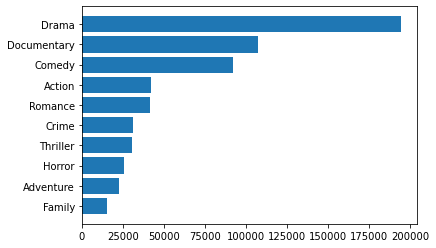

In [6]:
sort_genre_dict = dict(sorted(genre_dict.items(), key=lambda x: x[1], reverse=False))
topN = 10

names = list(sort_genre_dict.keys())[-1*topN:]
values = list(sort_genre_dict.values())[-1*topN:]

plt.barh(range(topN), values, tick_label=names)
plt.show()

#names = list(sort_genre_dict.keys())
#values = list(sort_genre_dict.values())

#plt.barh(range(len(names)), values, tick_label=names)
#plt.show()

### Determining the Trends for Each Genre

From the <code>title_ratings.tsv</code> dataset, we can load all the <code>averageRating</code> and <code>numVotes</code> for all the movie tag <code>tconst</code>.

In [7]:
iter_ratings = pd.read_csv('title_ratings.tsv', sep='\t', iterator=True, chunksize=10000)
df_ratings = pd.concat([chunk for chunk in iter_ratings])
print(df_ratings.head())

      tconst  averageRating  numVotes
0  tt0000001            5.7      1892
1  tt0000002            5.9       252
2  tt0000003            6.5      1682
3  tt0000004            5.7       165
4  tt0000005            6.2      2499


In [8]:
df_ratings.isna().sum()

tconst           0
averageRating    0
numVotes         0
dtype: int64

Now that we don't have empty rows, we can start defining the helper functions for our code.

In [9]:
### Function which takes the weighted average in a given list
# values  -> original data
# weights -> individual weight of data
# by      -> the property where the weighted average is grouped

def grouped_weighted_avg(values, weights, by):
    return (values * weights).groupby(by).sum() / weights.groupby(by).sum()

In [10]:
### Function which filters the movie dataset by genre
### This function returns df_yearly_rate which contains the weighted average rating for each year for the specified genre_string

def generate_genre_trend(genre_string):
    df_genre = []
    title_basics_col_list = ["tconst", "titleType", "primaryTitle", "startYear", "genres"]
    iter_genre = pd.read_csv('title_basics.tsv', sep='\t', usecols=title_basics_col_list, iterator=True, na_values = '\\N', chunksize=10000)
    df_genre = pd.concat([chunk[(chunk["genres"].str.contains(genre_string)) & (chunk['titleType']=="movie")] for chunk in iter_genre])
    #df_genre = pd.concat([chunk[(chunk["genres"].str.contains(genre_string)) & (chunk['titleType']=="movie")] for chunk in iter_movie])
    df_genre.drop(['titleType'], inplace=True, axis=1)
    df_genre = df_genre.reset_index(drop=True)
    #print(df_genre.head())
    df_genre_rating = pd.merge(df_genre,df_ratings,on='tconst')
    #print(df_genre_rating.head())
    
    x = grouped_weighted_avg(values=df_genre_rating.averageRating, weights=df_genre_rating.numVotes, by=df_genre_rating.startYear)
    
    df_yearly_rate = pd.DataFrame(x)
    df_yearly_rate.reset_index(inplace=True)
    df_yearly_rate.columns = ['year',genre_string]
    
    return df_yearly_rate
    

We can now iterate through the <code>names</code> variable which contains the top 10 genres, to determine the yearly weighted average by calling the function <code>generate_genre_trend</code>.

In [11]:
genre_list =  names

df_combined = []
for genre_string in genre_list:
    df_yearly_rate = generate_genre_trend(genre_string)
    if (len(df_combined) == 0):
        df_combined = df_yearly_rate
    else:
        df_combined = pd.merge(df_combined, df_yearly_rate, on = 'year')
        
    #plt.plot(df_yearly_rate['year'], df_yearly_rate['rating'])
    #plt.title('Movie Genre (' + genre_string + ')')
    #plt.xlabel('Year')
    #plt.ylabel('Average Rating')
    #plt.show()

In [12]:
df_combined.head()

,year,Family,Adventure,Horror,Thriller,Crime,Romance,Action,Comedy,Documentary,Drama
0,1914.0,5.349897,6.506497,6.474355,7.200000,6.612004,5.760659,6.048686,6.136364,7.545372,6.446963
1,1915.0,6.200000,6.845738,5.700000,5.923438,7.070676,6.319742,7.201309,6.027805,6.793966,6.253764
2,1916.0,3.700000,6.309175,6.434081,7.418605,6.601013,6.376057,6.218677,5.979894,6.560981,7.022361
3,1917.0,6.645485,5.976398,6.472756,5.918750,6.057831,6.311965,5.816449,6.263076,6.787838,6.391477
4,1918.0,6.721651,6.091222,5.344809,6.280723,5.169863,6.209298,5.932430,6.212723,6.359624,6.311276


From the data frame above, we were able to obtaine the yearly average for each genre. To simplify our visulization, we can start by observing only the column <code>Drama</code>.

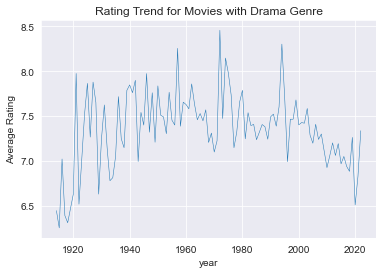

In [13]:
y = 'Drama'
x = 'year'
sns.set_style("darkgrid")
sns.lineplot(x=x, y=y, ci=None, data=df_combined, linewidth = 0.5)
plt.title('Rating Trend for Movies with Drama Genre')
plt.ylabel('Average Rating')
plt.show()


The plot has a lot of noise. To smoothen this out, we can take the moving average of the data.

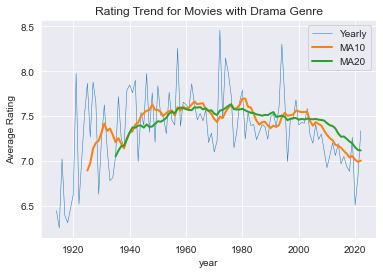

In [14]:
windowWidth10 = 10
windowWidth20 = 20
label10 = 'MA' + str(windowWidth10)
label20 = 'MA' + str(windowWidth20)
new_col = y+'_rollingAverage10'
df_combined[new_col] = df_combined['Drama'].rolling(windowWidth10).mean()

new_col2 = y+'_rollingAverage20'
df_combined[new_col2] = df_combined['Drama'].rolling(windowWidth20).mean()

sns.lineplot(x=x, y=y, ci=None, data=df_combined, linewidth = 0.5, label="Yearly")
sns.lineplot(x=x, y=new_col, ci=None, data=df_combined, linewidth = 2, label=label10)
sns.lineplot(x=x, y=new_col2, ci=None, data=df_combined, linewidth = 2, label=label20)
plt.title('Rating Trend for Movies with ' + y + ' Genre')
plt.ylabel('Average Rating')
plt.show()

In [15]:
def rollingAve(df_combined, genre):
    df_temp = df_combined[['year', genre]].copy()
    windowWidth10 = 10
    windowWidth20 = 20
    label10 = 'MA' + str(windowWidth10)
    label20 = 'MA' + str(windowWidth20)
    new_col = genre+'_rollingAverage10'
    df_temp[new_col] = df_temp[genre].rolling(windowWidth10).mean()

    new_col2 = genre+'_rollingAverage20'
    df_temp[new_col2] = df_temp[genre].rolling(windowWidth20).mean()

    sns.lineplot(x='year', y=genre, ci=None, data=df_temp, linewidth = 0.5, label="Yearly")
    sns.lineplot(x='year', y=new_col, ci=None, data=df_temp, linewidth = 2, label=label10)
    sns.lineplot(x='year', y=new_col2, ci=None, data=df_temp, linewidth = 2, label=label20)
    plt.title('Rating Trend for Movies with ' + genre + ' Genre')
    plt.ylabel('Average Rating')
    fig = plt.gcf()
    fig.set_size_inches(8,6)
    plt.savefig(genre+'_trend.png',dpi=100)
    plt.show()

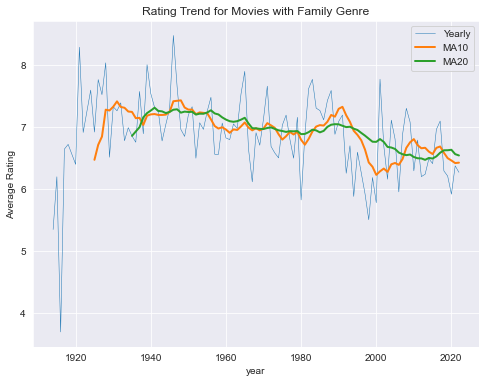

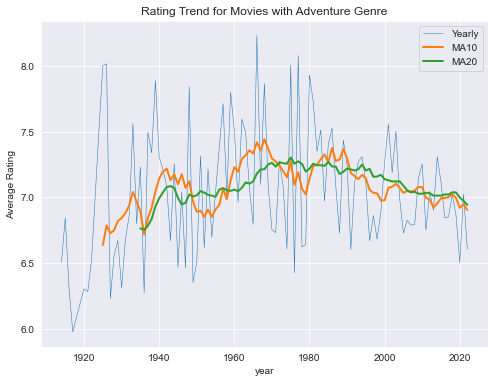

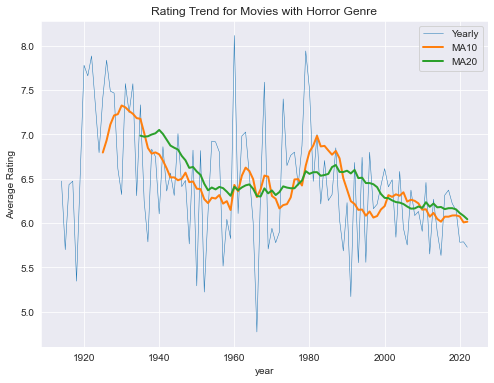

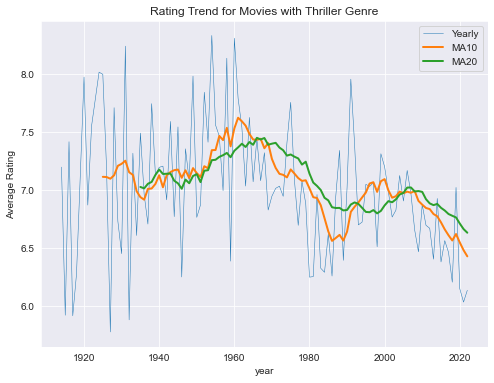

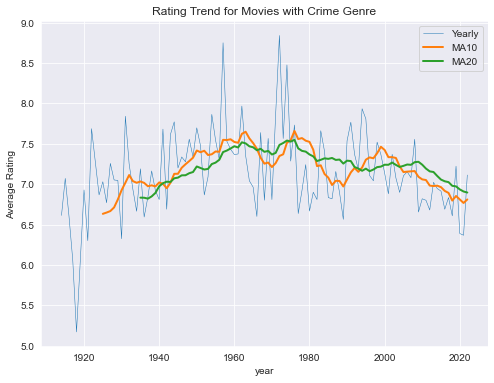

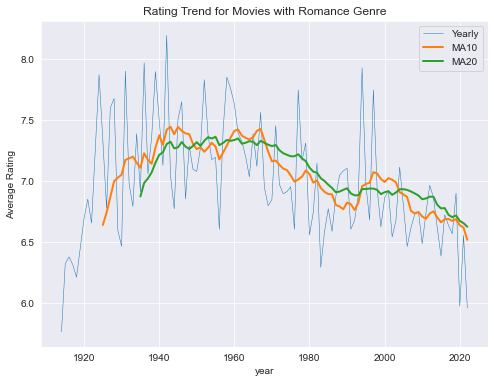

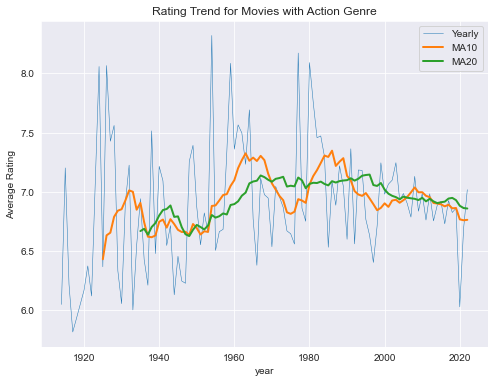

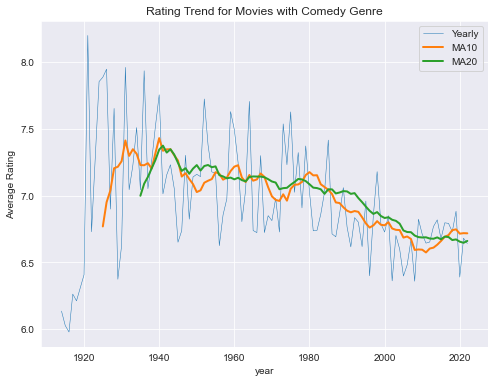

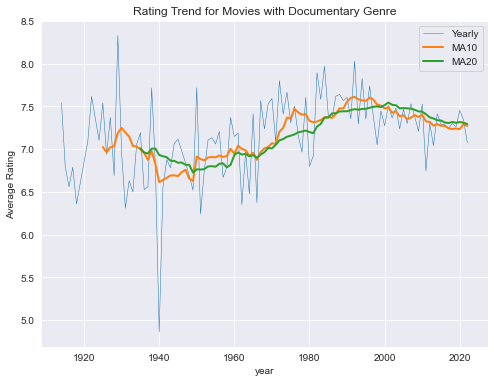

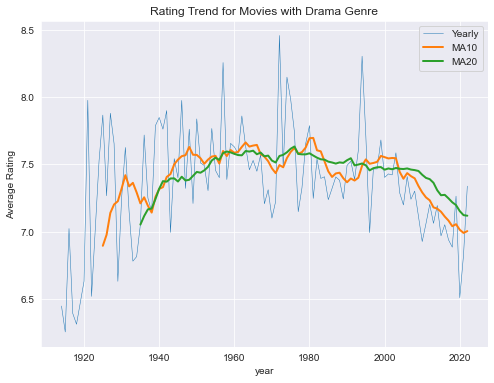

In [20]:
for genre in df_combined.columns[1:len(names)+1]:
    rollingAve(df_combined, genre)

### Conclusion

From the plots, we can observe a decline in the ratings of <code>Horror</code>, <code>Thriller</code>, <code>Romance</code> and <code>Comedy</code> genres. <code>Adventure</code>, <code>Family</code> and <code>Crime</code> genres are also seeing this slow decline in rating starting 1980s. Meanwhile <code>Action</code> and <code>Documentary</code> genres are showing a relatively steady trend in ratings. Over-all there is no observable increase in the movie rating for all of the top 10 genres within 1980 to 2022.